In [1]:
import numpy as np
from pylab import *
import res_utils as ru
from tqdm import tqdm

In [2]:
def dot_complex(vec1,vec2):
    num = np.dot(np.conj(vec1),vec2)
    denom = np.linalg.norm(vec1)*np.linalg.norm(vec2)
    return np.abs(num)/denom

In [3]:
N=200

#construct the seed vectors and codebook
xv1 = ru.cvecl(N, loopsize=3)
yv1 = ru.cvecl(N, loopsize=3)
zv1 = xv1**-1 * yv1**-1

xv2 = ru.cvecl(N, loopsize=5)
yv2 = ru.cvecl(N, loopsize=5)
zv2 = xv2**-1 * yv2**-1

xv3 = ru.cvecl(N, loopsize=7)
yv3 = ru.cvecl(N, loopsize=7)
zv3 = xv3**-1 * yv3**-1

gx1 = np.zeros((3, N), dtype='complex')
gy1 = np.zeros((3, N), dtype='complex')
gz1 = np.zeros((3, N), dtype='complex')

gx2 = np.zeros((5, N), dtype='complex')
gy2 = np.zeros((5, N), dtype='complex')
gz2 = np.zeros((5, N), dtype='complex')

gx3 = np.zeros((7, N), dtype='complex')
gy3 = np.zeros((7, N), dtype='complex')
gz3 = np.zeros((7, N), dtype='complex')

for i in range(3):
    gx1[i, :] = xv1**i
    gy1[i, :] = yv1**i
    gz1[i, :] = zv1**i

for i in range(5):
    gx2[i, :] = xv2**i
    gy2[i, :] = yv2**i
    gz2[i, :] = zv2**i

for i in range(7):
    gx3[i, :] = xv3**i
    gy3[i, :] = yv3**i
    gz3[i, :] = zv3**i

context = ru.crvec(N,4)
resonator = np.zeros((4, N), dtype='complex')
for i in range(3):
    resonator[i, :] = np.random.normal(0.0, 1.0, size=(
        1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
    resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

g1 = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            if i == 0 or j == 0 or k == 0:
                g1.append(gx1[i, :]*gy1[j, :]*gz1[k, :])
g1 = np.array(g1)

g2 = []
for i in range(5):
    for j in range(5):
        for k in range(5):
            if i == 0 or j == 0 or k == 0:
                g2.append(gx2[i, :]*gy2[j, :]*gz2[k, :])
g2 = np.array(g2)

g3 = []
for i in range(7):
    for j in range(7):
        for k in range(7):
            if i == 0 or j == 0 or k == 0:
                g3.append(gx3[i, :]*gy3[j, :]*gz3[k, :])
g3 = np.array(g3)

In [4]:
samps = 51
scale_fac = 0.1
pieces = 12
sims = np.zeros((pieces,samps,samps,8))

def sig(x):
    return 1/(1 + np.exp(-x)) 
alpha = sig(np.linspace(-5,5,8))

for i in tqdm(range(pieces)):
    a = np.array([1, 0])
    b = np.array([-1/2, np.sqrt(3)/2,])
    c = np.array([-1/2, -np.sqrt(3)/2])

    x0 = (np.random.uniform()-0.5)*8
    y0 = (np.random.uniform()-0.5)*8

    r = np.dot(a, np.array([x0,y0]))*scale_fac  # 3D coordinates
    s = np.dot(b, np.array([x0,y0]))*scale_fac
    t = np.dot(c, np.array([x0,y0]))*scale_fac

    #set the context
    if i < pieces/2:
        con_use = context[0,:]
    else:
        con_use = context[1,:]

    #bind the context to the position vector
    base_vec = con_use * (xv1 ** r) * (yv1 ** s) * (zv1 ** t) * (xv2 ** r) * (yv2 ** s) * (zv2 ** t) * (xv3 ** r) * (yv3 ** s) * (zv3 ** t)
    # base_vec = g2[1,:]*g2[1,:]*g3[1,:]#*context[2,:]
    x_space = np.linspace(-10, 10, samps)
    y_space = np.linspace(-10, 10, samps)
    x, y = np.meshgrid(x_space, y_space)
    for ix in range(x.shape[0]):
        for iy in range(y.shape[0]):
            for iz in range(8):

                a = np.array([1, 0])
                b = np.array([-1/2, np.sqrt(3)/2,])
                c = np.array([-1/2, -np.sqrt(3)/2])

                r = np.dot(a, np.array([x_space[ix], y_space[iy]]))*scale_fac  # 3D coordinates
                s = np.dot(b, np.array([x_space[ix], y_space[iy]]))*scale_fac
                t = np.dot(c, np.array([x_space[ix], y_space[iy]]))*scale_fac

                resonator[0,:] = (xv1 ** r) * (yv1 ** s) * (zv1 ** t)
                resonator[1,:] = (xv2 ** r) * (yv2 ** s) * (zv2 ** t)
                resonator[2,:] = (xv3 ** r) * (yv3 ** s) * (zv3 ** t)

                vec = resonator[0,:]*resonator[1,:]*resonator[2,:]*(alpha[iz]*context[0,:] + (1-alpha[iz])*context[1,:])
                sims[i,ix,iy,iz] = dot_complex(base_vec,vec)

100%|██████████| 12/12 [00:19<00:00,  1.63s/it]


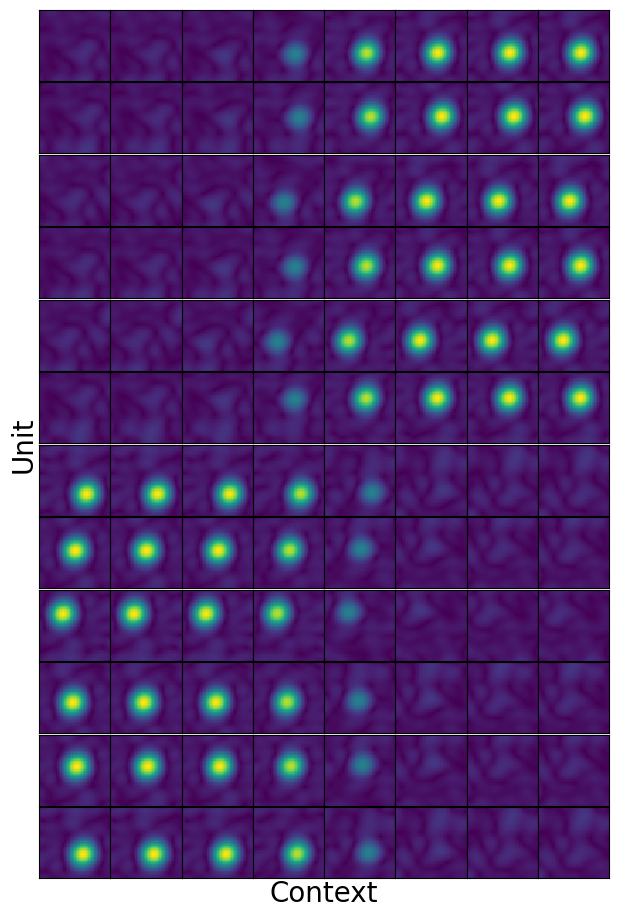

In [5]:
fig,ax = subplots(pieces,8,figsize=(6,9),dpi=100)

for i in range(pieces):
    for j in range(8):
        ax[i,j].matshow(sims[i,:,:,j],vmin=0,vmax=1)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
fig.tight_layout()
fig.text(0.5, 0.0, 'Context', ha='center', va='center',fontsize=20)
fig.text(0.0, 0.5, 'Unit', ha='center', va='center', rotation='vertical',fontsize=20)

subplots_adjust(wspace=0, hspace=0)
